In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

/Users/simennaess/Library/Python/3.8/lib/python/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [191]:

df=pd.read_csv('/Users/simennaess/Documents/Master/Ukentlig_vareid_ys_kunde_time_lag_15_20.csv', parse_dates=['Ukedato'], sep=";", decimal=",", header=0)



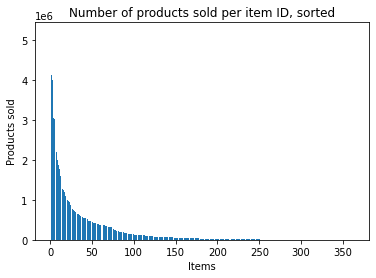

In [236]:

def df_split_into_top_mid_low_selling_products(df):
    df_topsalg=df.groupby(['Vare_Id']).agg({'Salg_sum':'sum'}).rename(columns={'Salg_sum':'Sales'})
    df_topsalg.sort_values(by='Sales', ascending=False,inplace=True)
    df_topsalg.reset_index(inplace=True)
    df_topsalg['Products']=df_topsalg.index
    plt.bar(df_topsalg.index, df_topsalg['Sales'])
    plt.ticklabel_format(useOffset=False)
    plt.xlabel('Items') 
    plt.ylabel('Products sold') 
    plt.title('Number of products sold per item ID, sorted')
    mid_number_of_rows=round(len(df_topsalg['Vare_Id'])/2)
    top_products=df_topsalg['Vare_Id'].head(10).to_list()
    mid_products=df_topsalg['Vare_Id'].iloc[65:75].to_list() # products with approx 50% sales volume of best sellers
    low_products=df_topsalg['Vare_Id'].iloc[140:150].to_list()  # products with approx 10% sales volume of best sellers
    return [top_products, mid_products, low_products]

#14418 should not be included as it lacks datapoints which HW does not accept(freq-term violation)
top10Products, mid10Products, low10Products = df_split_into_top_mid_low_selling_products(df)



In [315]:
#Produkter hentet fra produktseleksjon (vasket og deretter hentet ut basert på at de står for 100%, 50% eller 10% 
#av maksvolumet for enkeltprodukter, samt sesongprodukter. Blant allProducts er det også 12 
#ekstra produkter som ligger mellom mid-> low runners.)

selectedTopProducts=[10133,9662,9399,9306,9400,10135,9898,9630,9897,9860]
selectedMidProducts=[14759,9901,10019,14536,14508,9994,16444,16353,9995, 9307]
selectedLowProducts=[14238,14288,14542,10002,10197,16408,16527, 14563, 9541] 
selectedSeasonalProducts=[10022, 9560, 10005, 9541]

allSelectedProducts=[10133, 9662, 9399, 9306, 9400, 10135, 9898, 9630, 9897, 9860, 14759, 
                     9901, 10019, 14508, 9994, 16444, 16353, 9995, 9205, 14760, 15112, 14536, 16409, 
                     10022, 14540, 14251, 14490, 10017, 9560, 10005, 14238, 10002, 10197, 16408, 14288, 16527, 9541]


In [226]:
 def exp_smoothing_configs():
    models = list()
    # define config lists
    t_params = ['add', 'mul',None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                    for r in r_params:
                        cfg = [t,d,s,r]
                        models.append(cfg)
    return models

cfg_list = exp_smoothing_configs()

In [319]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)

    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100

    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))

    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)

    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))
    
    return MAPE

In [317]:
def HW_pred_with_parameter_tuning(df,product,horizon):
    df_prod = df.copy()
    #df_prod.asfreq('W-MON')
    #df_prod.index.freq ='W-MON'
    ind = df_prod.index[-horizon:] 
    train, test = df_prod.iloc[:-horizon], df_prod.iloc[-horizon:] #splits dataset according to chosen horrizon (weeks)
    
    #Tune parameters
    best_RMSE = np.inf
    best_config = []
    t1 = d1 = s1 = r1 = ''
    for j in range(len(cfg_list)):
        try: 
            cg = cfg_list[j]
            t,d,s,r = cg
            if t==None:             #don't dampen trend if it trend is not present
                model=ExponentialSmoothing(train, trend=t, seasonal=s, seasonal_periods=52).fit(optimized=True, remove_bias=r)
            else:                   #with and without the option of dampening
                model=ExponentialSmoothing(train, trend=t, damped_trend=d, seasonal=s, seasonal_periods=52).fit(optimized=True, remove_bias=r)
            pred1=model.predict(start=test.index[0], end=test.index[-1])
            rmse=np.sqrt(mean_squared_error(test,pred1))
            if rmse < best_RMSE:
                best_RMSE = rmse
                best_config = cfg_list[j]
        except ValueError as ve:
            print(ve)
    
    #Build model and run prediction
    t1,d1,s1,r1 = best_config
    
    if t1 == None:
        hw_model1 = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=52).fit(optimized=True, remove_bias=r1)
    else:
        hw_model1 = ExponentialSmoothing(train, trend=t1, seasonal=s1, seasonal_periods=52, damped=d1).fit(optimized=True, remove_bias=r1)
    
    pred_HW = hw_model1.predict(start=test.index[0], end = test.index[-1])
    
    #Concat predictions with real data. Currently not returned, haven't found use for is
    pred_HW = pd.Series(data=pred_HW, index=ind)
    df_pass_pred = pd.concat([df_prod, pred_HW.rename('pred_HW')], axis=1)
    
    #Statistics of each model performance
    print('-*-'*20)
    print("Vare_Id: ",product)
    mape=model_eval(test, pred_HW)
    print('-*-'*20)
    
    #Visual inspection
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(pred_HW.index, pred_HW, label='Holt-Winters')
    plt.legend(loc='best');
    plt.show()
    
    return [best_RMSE,mape]
    

In [294]:

def HW_iterator_for_products(df, products, horizon):
    total_rmse=0
    total_mape=0
    for product in products: 
        print("Current product: ", product)
        df_prod_select=df.loc[df['Vare_Id']==product]
        df_prod=df_prod_select.groupby(['Ukedato'])['Salg_sum'].sum().reset_index()
        df_prod=df_prod[['Ukedato','Salg_sum']]
        df_prod.index = pd.DatetimeIndex(df_prod["Ukedato"])
        df_prod=df_prod['Salg_sum'].resample('W-MON').asfreq().fillna(0)
        #df_prod.set_index('Ukedato',inplace=True)
        errors=HW_pred_with_parameter_tuning(df_prod,product, horizon)
        total_rmse+=errors[0]
        total_mape+=errors[1]
        
    print("Total RMSE of top 10 selling products: ", total_rmse, ", total mape: ",total_mape)
    
        
        

In [302]:
## Run all the methods

productMixes=[selectedTopProducts,selectedMidProducts,selectedLowProducts,selectedSeasonalProducts,allSelectedProducts]


product1Mixes=[selectedLowProducts,selectedSeasonalProducts,allSelectedProducts]

pM=[selectedSeasonalProducts]

horizons=[3,12]

def main_method(prodMix,horizons):
    for prod in prodMix:
        print("selected products: ",prod)
        for h in horizons:
            print("selected horizon: ",h)
            HW_iterator_for_products(df,prod,h)





selected products:  [14536]
selected horizon:  12
Current product:  14536
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  14536
Mean Absolute Error: 146.265
Mean Squared Error: 1411.725
Root Mean Squared Error: 188.8
Mean absolute percentage error: 9.765
Scaled Mean absolute percentage error: 10.519
Mean forecast error: 1256.798
Normalised mean squared error: 0.702
Theil_u_statistic: 0.0
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


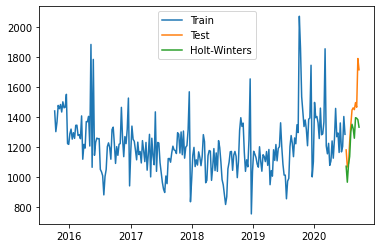

Total RMSE of top 10 selling products:  188.80011917951578 , total mape:  9.764815303800505


In [320]:
main_method([[14536]],[12])


selected products:  [9307]
selected horizon:  12
Current product:  9307
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
Vare_Id:  9307
Mean Absolute Error: 125.079
Mean Squared Error: 1601.176
Root Mean Squared Error: 153.027
Mean absolute percentage error: 7.629
Scaled Mean absolute percentage error: 7.696
Mean forecast error: 1593.82
Normalised mean squared error: 0.769
Theil_u_statistic: 0.0
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


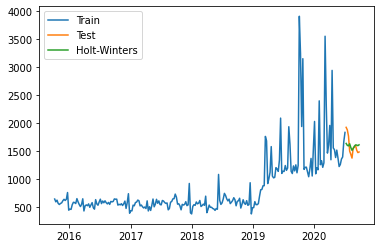

Total RMSE of top 10 selling products:  153.0272193200514 , total mape:  7.628602280308982


In [321]:
main_method([[9307]],[12])